In [14]:
import os
import json
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import portpicker
import numpy as np
from keras.preprocessing import image
import tkinter as tk
from tkinter import *   
from tkinter import filedialog

In [ ]:
!wget --no-check-certificate \ "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \ -O "tmps/cats-and-dogs.zip"

local_zip = 'tmps/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmps')
zip_ref.close()

In [4]:
# Use this function if you want to train the model on cloud GPU's

chief_port = portpicker.pick_unused_port()
worker_ports = [portpicker.pick_unused_port() for _ in range(3)]
ps_ports = [portpicker.pick_unused_port() for _ in range(2)]

# Dump the cluster information to `'TF_CONFIG'`.
tf_config = {
    'cluster': {
        'chief': ["localhost:%s" % chief_port],
        'worker': ["localhost:%s" % port for port in worker_ports],
        'ps':  ["localhost:%s" % port for port in ps_ports],
    },
    'task': {'type': 'chief', 'index': 0}
}
os.environ['TF_CONFIG'] = json.dumps(tf_config)

# Use a cluster resolver to bridge the information to the strategy created below.
cluster_resolver = tf.distribute.cluster_resolver.TFConfigClusterResolver()
strategy = tf.distribute.experimental.ParameterServerStrategy(cluster_resolver)

INFO:tensorflow:`tf.distribute.experimental.ParameterServerStrategy` is initialized with cluster_spec: ClusterSpec({'chief': ['localhost:17353'], 'ps': ['localhost:18097', 'localhost:19700'], 'worker': ['localhost:21805', 'localhost:22089', 'localhost:22758']})
INFO:tensorflow:ParameterServerStrategyV2 is now connecting to cluster with cluster_spec: ClusterSpec({'chief': ['localhost:17353'], 'ps': ['localhost:18097', 'localhost:19700'], 'worker': ['localhost:21805', 'localhost:22089', 'localhost:22758']})


In [15]:
source_path = 'tmps/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


FIND: Invalid switch


In [16]:
# defining root directory
root_dir = 'tmps/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# creating train, test, and validation subfolders
def create_train_val_dirs(root_path):
  # Creates directories for the train and test sets
  train_dir = os.path.join(root_dir,'training')
  validation_dir = os.path.join(root_dir,'validation')


  train_cats_dir = os.path.join(train_dir,'cats')
  train_dogs_dir = os.path.join(train_dir,'dogs')

  validation_cats_dir = os.path.join(validation_dir,'cats')
  validation_dogs_dir = os.path.join(validation_dir,'dogs')

  os.makedirs(train_dir)
  os.makedirs(validation_dir)
  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)
  os.makedirs(validation_cats_dir)
  os.makedirs(validation_dogs_dir)

  pass

# Copying files to train and validation directories
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [17]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

tmps/cats-v-dogs\training
tmps/cats-v-dogs\validation
tmps/cats-v-dogs\training\cats
tmps/cats-v-dogs\training\dogs
tmps/cats-v-dogs\validation\cats
tmps/cats-v-dogs\validation\dogs


In [20]:
# split the data into train and test (validation) sets
import numpy as np

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  
  files = []
  for filename in os.listdir(SOURCE_DIR):
    File = SOURCE_DIR + filename
    if os.path.getsize(File)>0:
      files.append(filename)
    else:
      print("file is empty ignoring")

  training_len = int(len(files)*SPLIT_SIZE)
  validation_len = int(len(files) - training_len)

  shuffled_data = random.sample(files,len(files))
  training_data = shuffled_data[0:training_len]
  validation_data = shuffled_data[-validation_len:]

  for filename in training_data:
    src = SOURCE_DIR + filename
    dest = TRAINING_DIR + filename
    shutil.copyfile(src,dest)

  for filename in validation_data:
    src = SOURCE_DIR + filename
    dest = VALIDATION_DIR + filename
    shutil.copyfile(src,dest)
  
  pass

In [21]:
# Define paths
CAT_SOURCE_DIR = "tmps/PetImages/Cat/"
DOG_SOURCE_DIR = "tmps/PetImages/Dog/"

TRAINING_DIR = "tmps/cats-v-dogs/training/"
VALIDATION_DIR = "tmps/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

file is empty ignoring
file is empty ignoring


Original cat's directory has 12501 images
Original dog's directory has 12501 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [22]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Creates the training and validation data generators


  # Instantiate the ImageDataGenerator class to do data augmentation
  train_datagen = ImageDataGenerator(rescale = 1.0/255.)

  # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 128,
                                                      class_mode = 'binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 16,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [23]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [30]:
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS (USE MORE BUT TAKES MORE TIME)

  ### START CODE HERE
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512,activation = 'relu'),
      tf.keras.layers.Dense(1,activation='sigmoid')
  ])

    
  model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics=['accuracy']) 
    
  return model


In [31]:
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data = validation_generator)

Epoch 1/15
  6/176 [>.............................] - ETA: 3:06 - loss: 0.7030 - accuracy: 0.5091

c:\Users\Siddharth\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 [==============================] - 214s 1s/step - loss: 0.6562 - accuracy: 0.6150 - val_loss: 0.5922 - val_accuracy: 0.6740
Epoch 2/15
176/176 [==============================] - 115s 651ms/step - loss: 0.5800 - accuracy: 0.6918 - val_loss: 0.5258 - val_accuracy: 0.7356
Epoch 3/15
176/176 [==============================] - 104s 590ms/step - loss: 0.5129 - accuracy: 0.7486 - val_loss: 0.5346 - val_accuracy: 0.7280
Epoch 4/15
176/176 [==============================] - 118s 671ms/step - loss: 0.4623 - accuracy: 0.7828 - val_loss: 0.4620 - val_accuracy: 0.7796
Epoch 5/15
176/176 [==============================] - 118s 668ms/step - loss: 0.4170 - accuracy: 0.8050 - val_loss: 0.4236 - val_accuracy: 0.8064
Epoch 6/15
176/176 [==============================] - 117s 664ms/step - loss: 0.3805 - accuracy: 0.8286 - val_loss: 0.3962 - val_accuracy: 0.8128
Epoch 7/15
176/176 [==============================] - 117s 664ms/step - loss: 0.3404 - accuracy: 0.8475 - val_loss: 0.3663 - val_accuracy:

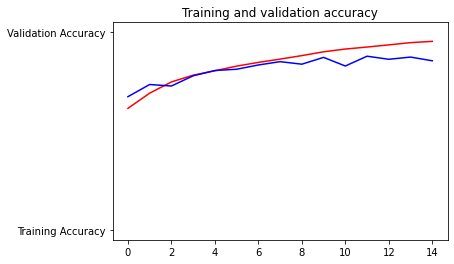

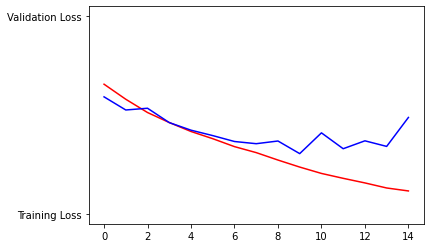

In [32]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
'''
# Evaluate the model on the test data using `evaluate`
# With using tkinter we can custom load the file and then choose the image letting the Model to predict the class
# The model will predict the class of the image and the accuracy of the model will be displayed

def openfile():
    filename = filedialog.askopenfilename()
    return filename

parent = tk.Tk()
frame = tk.Frame(parent)
frame.pack()

text_disp= tk.Button(frame, 
                   text="open file ", 
                   command=openfile
                   )

text_disp.pack(side=tk.LEFT)

exit_button = tk.Button(frame,
                   text="Exit",
                   fg="green",
                   command=quit)
exit_button.pack(side=tk.RIGHT)

parent.mainloop()


# create a windown with title "select image for classification" and button to select the file
root = Tk()
root.title("select image for classification")
root.geometry("300x100")
button = Button(root, text="Select Image", command=openfile)
button.pack() 
root.mainloop()  
'''

fn = "imagetest/anotherimage.jfif"

# predicting images
path = fn
img = tf.keras.utils.load_img(path, target_size=(150, 150))
x = tf.keras.utils.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

# display the image in the path 
plt.imshow(img)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print(fn + " is a cat")
else:
    print(fn + " is a dog")